# Multi-agent roundabout crossing

In [1]:
%matplotlib inline

import cvxpy as cvx
import dccp
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib.patches import Circle, Rectangle
import random
import os

In [2]:
start_points = [np.array([0.48, 0.]), np.array([0.88, 0.06]), np.array([ 0.079, -0.81]), np.array([0.33, -0.33])]
z = np.array([0.02, 1.3])
o, p1, p2, p3, p4 = np.array([0., 0.]), np.array([1., 1.]), np.array([-1., 1.]), np.array([-1., -1.]), np.array([1., -1.])

r_center_in, r_center_out = 0.40, 0.50
r_center_middle = (r_center_in + r_center_out) / 2

r_curve_in, r_curve_out = 0.88, 0.98
r_curve_middle = (r_curve_in + r_curve_out) / 2
min_dist = 0.14

dx = 0.1

n = 60
m = 4

In [3]:
x_vars = [cvx.Variable((n+1, 2)) for _ in range(m)]

In [4]:
constr = [x[0] == s for (x, s) in zip(x_vars, start_points)]
constr.extend([x[n][0] >= z[0] for x in x_vars])
constr.extend([x[n][1] >= z[1] for x in x_vars])

In [5]:
v_vars = [x[1:] - x[:-1] for x in x_vars]

In [6]:
for t in range(1, n+1):
    for i in range(m):
        x, v = x_vars[i], v_vars[i]
        constr.append(cvx.norm(v[t-1]) <= dx)
        constr.append(cvx.norm(x[t] - o) >= r_center_in)
        constr.append(cvx.norm(x[t] - p1) >= r_curve_in)
        
        for j in range(i+1, m):
            x2 = x_vars[j]
            constr.append(cvx.norm(x2[t] - x[t]) >= min_dist)

In [7]:
total_v = sum([cvx.norm(v, "fro") for v in v_vars])

prob = cvx.Problem(cvx.Minimize(total_v), constr)
prob.is_dcp()

False

In [8]:
prob.solve(method="dccp");

In [9]:
trajs = [x.value for x in x_vars]

In [10]:
colors = ["red", "blue", "orange", "purple", "pink"]

In [23]:
def draw_traj(trajs, traj_id=0):
    dir_name = "traj_{}".format(traj_id)
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

    for i in range(0, len(trajs[0]), 5):
        fig = plt.figure()
        plt.title("$t={}$".format(i))
        draw_roundabout(fig.gca())
        
        for j, traj in enumerate(trajs):
            x, y = traj[i]
            angle = get_angle(x, y)
            draw_vehicle(fig.gca(), x, y, angle=angle, color=colors[j])
            plt.savefig("{}/{}.jpg".format(dir_name, i))

In [14]:
def norm(vec):
    return np.sqrt(np.sum(vec**2))

def get_angle(x, y):
    eps = 0.01
    
    pos = np.array([x, y])
    
    if norm(pos - p1) <= r_curve_out + eps:
        v = pos - p1
        return np.arctan2(v[1], v[0])
    
    if norm(pos - p2) <= r_curve_out + eps:
        v = pos - p2
        return np.arctan2(v[1], v[0])
    
    if norm(pos - p3) <= r_curve_out + eps:
        v = pos - p3
        return np.arctan2(v[1], v[0])
    
    if norm(pos - p4) <= r_curve_out + eps:
        v = pos - p4
        return np.arctan2(v[1], v[0])
    
    if norm(pos - o) <= r_center_out - eps:
        v = pos - o
        return np.arctan2(v[1], v[0])

    return 0.

In [15]:
def draw_roundabout(ax):
    center_green = Circle((0, 0), radius=0.4, color="forestgreen", zorder=20)
    center_road_in = Circle((0, 0), radius=r_center_in, color="darkgray", zorder=20, linewidth=1, fill=False)
    center_road_out = Circle((0, 0), radius=r_center_out, color="darkgray", zorder=20, linewidth=1, fill=False)
    center_lines = Circle((0, 0), radius=r_center_middle, color="white", zorder=20, linewidth=1, linestyle="--", fill=False)
    center_road = Circle((0, 0), radius=r_center_middle, color="darkgray", zorder=20, linewidth=12, fill=False)
    ax.add_patch(center_green); ax.add_patch(center_road); ax.add_patch(center_road_in); ax.add_patch(center_road_out); ax.add_patch(center_lines)

    deco1 = Circle((0, -0.05), radius=0.2, color="yellowgreen", zorder=20)
    deco2 = Circle((0.1, 0.05), radius=0.15, color="olivedrab", zorder=20)
    ax.add_patch(deco1); ax.add_patch(deco2)

    road_NE_in = Circle((1., 1.), radius=r_curve_in, color="darkgray", zorder=10, linewidth=1, fill=False)
    road_NW_in = Circle((-1., 1.), radius=r_curve_in, color="darkgray", zorder=10, linewidth=1, fill=False)
    road_SE_in = Circle((1., -1.), radius=r_curve_in, color="darkgray", zorder=10, linewidth=1, fill=False)
    road_SW_in = Circle((-1., -1.), radius=r_curve_in, color="darkgray", zorder=10, linewidth=1, fill=False)
    ax.add_patch(road_NE_in); ax.add_patch(road_NW_in); ax.add_patch(road_SE_in); ax.add_patch(road_SW_in);
    
    road_NE_out = Circle((1., 1.), radius=r_curve_out, color="darkgray", zorder=10, linewidth=1, fill=False)
    road_NW_out = Circle((-1., 1.), radius=r_curve_out, color="darkgray", zorder=10, linewidth=1, fill=False)
    road_SE_out = Circle((1., -1.), radius=r_curve_out, color="darkgray", zorder=10, linewidth=1, fill=False)
    road_SW_out = Circle((-1., -1.), radius=r_curve_out, color="darkgray", zorder=10, linewidth=1, fill=False)
    ax.add_patch(road_NE_out); ax.add_patch(road_NW_out); ax.add_patch(road_SE_out); ax.add_patch(road_SW_out);
    
    road_NE = Circle((1., 1.), radius=r_curve_middle, color="darkgray", zorder=10, linewidth=14, fill=False)
    road_NW = Circle((-1., 1.), radius=r_curve_middle, color="darkgray", zorder=10, linewidth=14, fill=False)
    road_SE = Circle((1., -1.), radius=r_curve_middle, color="darkgray", zorder=10, linewidth=14, fill=False)
    road_SW = Circle((-1., -1.), radius=r_curve_middle, color="darkgray", zorder=10, linewidth=14, fill=False)
    ax.add_patch(road_NE); ax.add_patch(road_NW); ax.add_patch(road_SE); ax.add_patch(road_SW);

    lines_NE = Circle((1., 1.), radius=0.93, color="white", zorder=15, linewidth=1, linestyle="--", fill=False)
    lines_NW = Circle((-1., 1.), radius=0.93, color="white", zorder=15, linewidth=1, linestyle="--", fill=False)
    lines_SE = Circle((1., -1.), radius=0.93, color="white", zorder=15, linewidth=1, linestyle="--", fill=False)
    lines_SW = Circle((-1., -1.), radius=0.93, color="white", zorder=15, linewidth=1, linestyle="--", fill=False)
    ax.add_patch(lines_NE); ax.add_patch(lines_NW); ax.add_patch(lines_SE); ax.add_patch(lines_SW);
    
    plt.axis('square')
    plt.xlim(-1, 1);
    plt.ylim(-1, 1);
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(tick1On=False)
    
    ax.set_facecolor((0.43, 0.98, 0.4))
    plt.grid(True, color=(0.42, 0.87, 0.39), linewidth=15)
    
def draw_vehicle(ax, x=0, y=0, angle=0, color="red"):
    w, h = 0.03, 0.1
    vehicle = Rectangle((x-w/2, y-h/2), w, h, color=color, zorder=50)
    
    # t = ax.transData + transforms.Affine2D().rotate_deg_around(x, y, np.rad2deg(angle))
    t = transforms.Affine2D().rotate_deg_around(x, y, np.rad2deg(angle)) + ax.transData 
    
    vehicle.set_transform(t)
    ax.add_patch(vehicle)

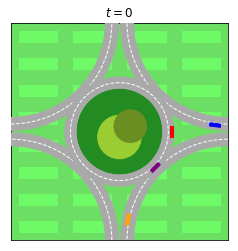

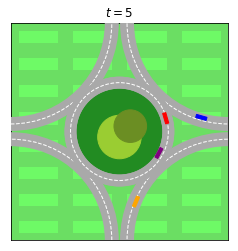

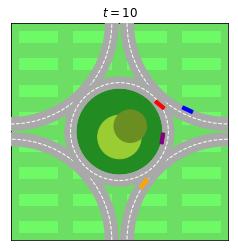

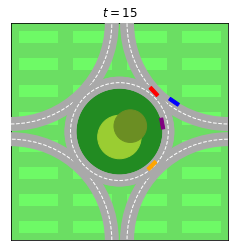

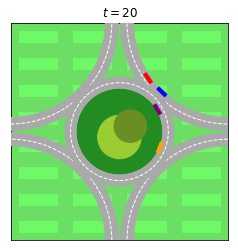

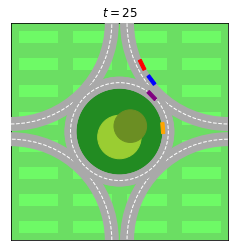

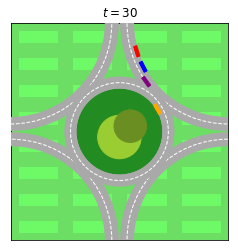

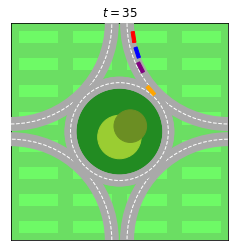

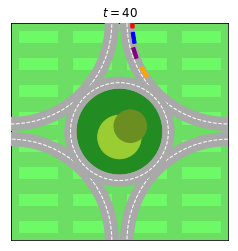

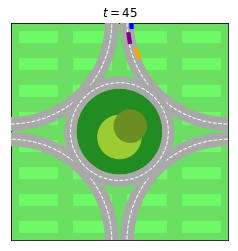

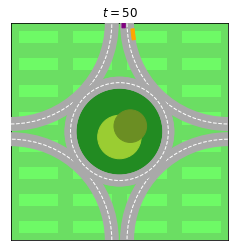

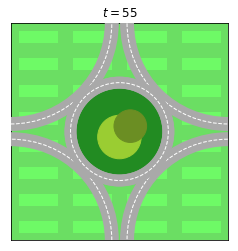

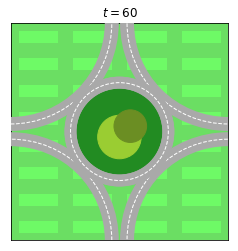

In [24]:
draw_traj(trajs)